In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from PIL import Image
import io
import datetime
import cv2

___
# CLASSIFICATOR FITTING

Example mainly adopted from

https://www.kaggle.com/code/texasdave/image-classification-tutorial-with-mnist-fashion

Date (2023-10-17)

By T. Glaubach
___

In [2]:
import random

In [3]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%pip show tensorflow


Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [6]:
# classifier = r"C:\Users\tobia\Nextcloud\Shared\SKA_MPG_Tests\RF_Poinint\rfi_flagging\KuBandClassifier.pkl"
path = "/content/drive/MyDrive/data/NEW_tagging_db.sqlite"

out_mdl_name = datetime.datetime.now().strftime('%Y%m%d') + '_cnn_model_nclasses.keras'


In [7]:
out_mdl_name

'20231017_cnn_model_nclasses.keras'

In [8]:
def get_rows(select_sql = "SELECT * FROM observation_tagging;"):

    try:
        con = sqlite3.connect(path)

        with con:
            df = pd.read_sql_query(select_sql, con)
            df = df.loc[:, ~df.columns.duplicated()]
            print(df.columns)
            return df.to_dict('records')
    finally:
        if 'con' in locals() and con:
            con.close()

In [9]:
rows = get_rows('SELECT * FROM observation_tagging INNER JOIN rows on rows.obs_id = observation_tagging.obs_id ORDER BY scn_time_unx')

Index(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier',
       'clf_chksum', 'sysinfo', 'scn_no', 'scn_time_unx', 'src_ra', 'src_dec',
       'src_id', 'src_flux', 'pk_amp', 'pk_az', 'pk_el', 'pk_az_appl_corr',
       'pk_el_appl_corr', 'pk_time', 'pk_bckgrnd', 'pk_bck_p0', 'pk_bck_dx',
       'pk_bck_dy', 'fit_A', 'fit_x0', 'fit_y0', 'fit_sx', 'fit_sy', 'fit_b',
       'fit_gof', 'obs_epoch', 'fname'],
      dtype='object')


In [10]:
rows = get_rows()
for i in range(len(rows)):
    rows[i]['image'] = np.array(Image.open(io.BytesIO(rows[i]['image'])), dtype=np.uint8)

Index(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier',
       'clf_chksum', 'sysinfo'],
      dtype='object')


In [11]:
rows[0].keys()

dict_keys(['obs_id', 'filename', 'image', 'tags', 'time_changed', 'classifier', 'clf_chksum', 'sysinfo'])

In [12]:
fitting_rows = [r for r in rows if r['classifier'] == 'manual' or r['tags'] == 'good']

___
# EXPLORE THE DATASET
___

In [13]:
targets = [r['tags'] for r in fitting_rows]
targets = pd.Series(targets)
targets.value_counts() / len(targets)

HIGH_RFI     0.385549
good         0.205202
BAD_SHAPE    0.165896
LOW_SNR      0.121965
NO_SRC       0.121387
dtype: float64

In [14]:
out_mdl_name = out_mdl_name.replace('nclasses', f'{len(targets.unique())}Classes')

In [15]:
targets.value_counts()

HIGH_RFI     667
good         355
BAD_SHAPE    287
LOW_SNR      211
NO_SRC       210
dtype: int64

In [16]:
for k in targets.unique():
    print(k)

good
LOW_SNR
HIGH_RFI
BAD_SHAPE
NO_SRC


In [17]:
def get_concat_h(images):
    w = np.sum([img.width for img in images])
    h = images[0].height
    dst = Image.new('RGB', (w, h))
    x0, y0 = 0,0
    for img in images:
        dst.paste(i, (x0, y0))
        x0 += img.width
    return dst
def get_concat_w(images):
    h = np.sum([img.height for img in images])
    w = images[0].width
    dst = Image.new('RGB', (w, h))
    x0, y0 = 0,0
    for img in images:
        dst.paste(i, (x0, y0))
        y0 += img.height
    return dst



In [18]:
n_rows = n_cols = 5

In [19]:
def plot_sample_img(rows, n_rows=5, n_cols=5, title='', ax=None):

    if ax is None:
        ax = plt.subplot(111)

    img0 = rows[0]['image']
    n, m = img0.shape
    full_img = np.zeros((n*n_rows, m*n_cols), dtype=np.uint8)
    slices = []

    i = 0
    for ir in range(n_rows):
        for ic in range(n_cols):
            if i >= len(rows):
                break
            sx = slice(ir*m, (ir+1)*m)
            sy = slice(ic*m, (ic+1)*m)

            full_img[sx, sy] = rows[i]['image']
            i += 1
    ax.imshow(full_img)
    ax.set_title(title)


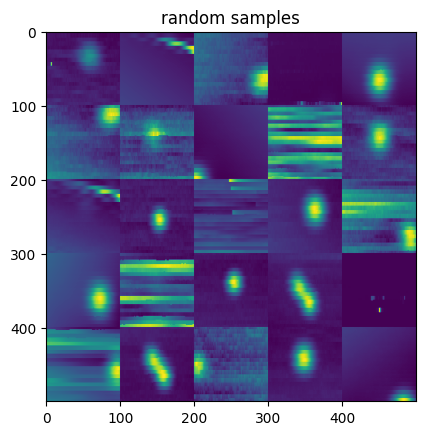

In [20]:
plot_sample_img(random.sample(fitting_rows, n_rows*n_cols), n_rows, n_cols, 'random samples')

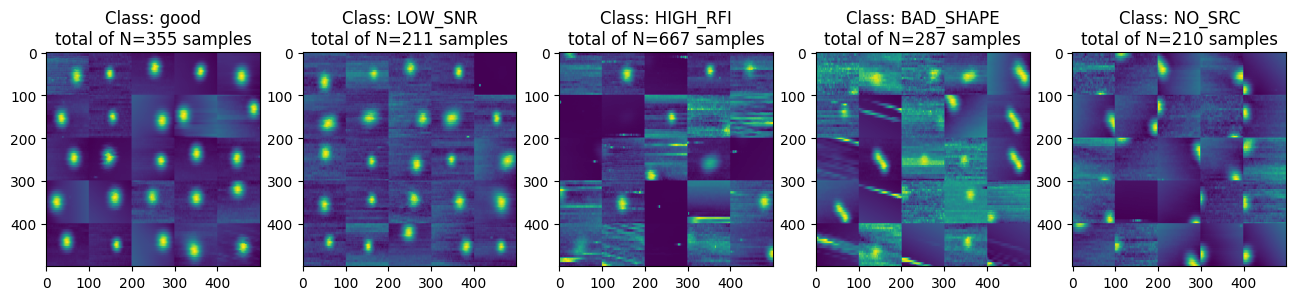

In [21]:
f, axs = plt.subplots(1, len(targets.unique()), figsize=(16,5))

for k, ax in zip(targets.unique(), axs):
    smpls = [r for r in fitting_rows if r['tags'] == k]
    plot_sample_img(random.sample(smpls, n_rows*n_cols), n_rows, n_cols, f'Class: {k}\ntotal of N={len(smpls)} samples', ax)

## Group some classes together to increase sample size (and performance?)

In [22]:
groups = {
   'good': ['good', 'LOW_SNR'],
   'HIGH_RFI': ['HIGH_RFI'],
   'BAD_SHAPE': ['BAD_SHAPE', 'NO_SRC']
}

for kg, vg in groups.items():
    for i in range(len(fitting_rows)):
        if fitting_rows[i]['tags'] in vg:
            fitting_rows[i]['tags'] = kg

___
# Prepare the data used for fitting
___

In [23]:
targets = [r['tags'] for r in fitting_rows]
targets = pd.Series(targets)
counts = targets.value_counts()

n_good = counts['good']

display(counts)
display(counts / n_good)

HIGH_RFI     667
good         566
BAD_SHAPE    497
dtype: int64

HIGH_RFI     1.178445
good         1.000000
BAD_SHAPE    0.878092
dtype: float64

Get number of samples from class 'good' and round to nearest lower hundrets


In [24]:
n_per_class = counts['good'] #  // 100 * 100
n_per_class

566

In [25]:
# randomply select samples
input_data = []
for k in targets.unique():
    rows_i = [r for r in fitting_rows if r['tags'] == k]
    input_data += random.sample(rows_i, min(n_per_class, counts[k]))

# shuffle the selected samples
random.shuffle(input_data)


In [26]:
targets = [r['tags'] for r in input_data]
targets = pd.Series(targets)
counts = targets.value_counts()

n_good = counts['good']

display(counts)
display(counts / n_good)

good         566
HIGH_RFI     566
BAD_SHAPE    497
dtype: int64

good         1.000000
HIGH_RFI     1.000000
BAD_SHAPE    0.878092
dtype: float64

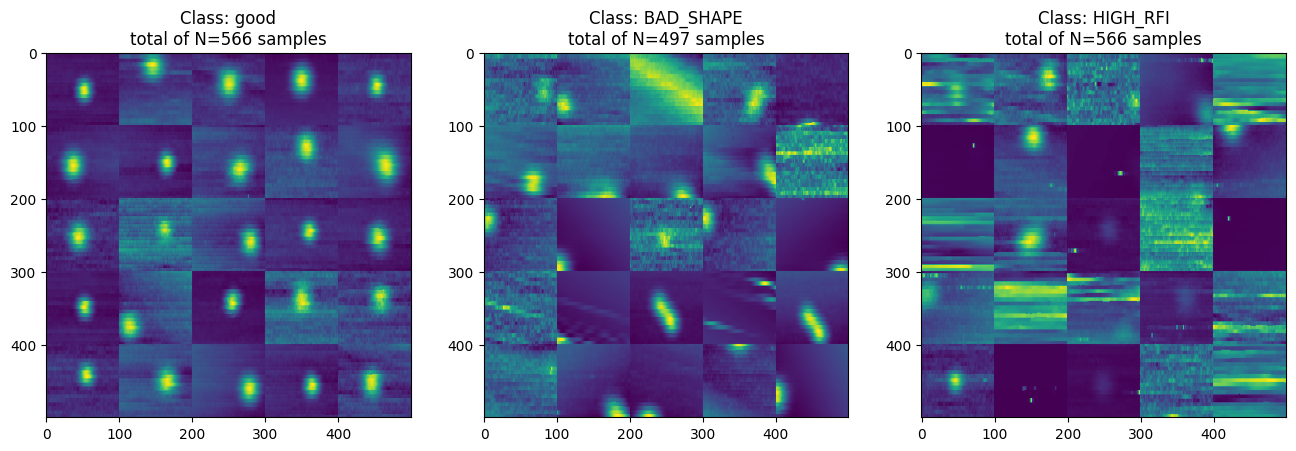

In [27]:
f, axs = plt.subplots(1, len(targets.unique()), figsize=(16,5))

for k, ax in zip(targets.unique(), axs):
    smpls = [r for r in input_data if r['tags'] == k]
    plot_sample_img(random.sample(smpls, n_rows*n_cols), n_rows, n_cols, f'Class: {k}\ntotal of N={len(smpls)} samples', ax)

In [28]:
df = pd.DataFrame(input_data)
df[[c for c in df.columns if c != 'image']]

obs_id                                           filename       tags  \
0      35540  /data/output/2023/10/13/EDD_2023-10-13T01:24:1...       good   
1      23443  /data/output/2023/03/24/EDD_2023-03-24T05:43:1...  BAD_SHAPE   
2      35863  /data/output/2023/10/16/EDD_2023-10-16T00:36:2...  BAD_SHAPE   
3      34904  /data/output/2023/10/07/EDD_2023-10-07T02:03:5...       good   
4      24075  /data/output/2023/04/03/EDD_2023-04-03T04:20:1...       good   
...      ...                                                ...        ...   
1624   34753  /data/output/2023/10/05/EDD_2023-10-05T04:59:1...   HIGH_RFI   
1625   24328  /data/output/2023/04/04/EDD_2023-04-04T12:52:4...       good   
1626   35259  /data/output/2023/10/10/EDD_2023-10-10T10:39:2...   HIGH_RFI   
1627   35357  /data/output/2023/10/11/EDD_2023-10-11T07:31:3...  BAD_SHAPE   
1628   35229  /data/output/2023/10/10/EDD_2023-10-10T04:40:4...  BAD_SHAPE   

                  time_changed                classifier  \
0     2023-10-13 13:08:35.790Z  20231011_cnn_model.keras   
1     2023-10-17 09:04:09.593Z                    manual   
2     2023-10-17 10:07:38.011Z                    manual   
3     2023-10-15 18:26:21.046Z  20231011_cnn_model.keras   
4     2023-10-17 09:23:38.455Z                    manual   
...                        ...                       ...   
1624  2023-10-17 09:29:47.596Z                    manual   
1625  2023-10-13 14:16:59.533Z  20231011_cnn_model.keras   
1626  2023-10-17 09:52:29.615Z                    manual   
1627  2023-10-17 09:56:02.804Z                    manual   
1628  2023-10-17 09:51:40.347Z                    manual   

                            clf_chksum                        sysinfo  
0     2367e79ff710711caedd9f81fa75fddb  jovyan | Linux | 40217aae6c82  
1                               manual  jovyan | Linux | 40217aae6c82  
2                               manual  jovyan | Linux | 40217aae6c82  
3     2367e79ff710711caedd9f81fa75fddb  jovyan | Linux | 40217aae6c82  
4                               manual  jovyan | Linux | 40217aae6c82  
...                                ...                            ...  
1624                            manual  jovyan | Linux | 40217aae6c82  
1625  2367e79ff710711caedd9f81fa75fddb  jovyan | Linux | 40217aae6c82  
1626                            manual  jovyan | Linux | 40217aae6c82  
1627                            manual  jovyan | Linux | 40217aae6c82  
1628                            manual  jovyan | Linux | 40217aae6c82  

[1629 rows x 7 columns]

In [29]:
rows_backup = rows
rows = input_data

___
# TRAIN CLF
___

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
import keras
from keras import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, LeakyReLU
# from keras.layers.advanced_activations import
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

# Make DataSet

In [32]:
# resize = lambda img: cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

# no resizing since it did not yield any accuracy improvement
resize = lambda img: img

In [33]:
X = np.array([resize(r['image']) for r in rows])
X.shape

(1629, 100, 100)

In [34]:
targets = np.array([r['tags'] for r in rows])
classes = np.unique(targets)

dc = dict(zip(classes,np.arange(len(classes))))

targets_int = np.array([dc[x] for x in targets])

display(targets_int)

y = to_categorical(targets_int)
y

array([2, 0, 0, ..., 1, 0, 0])

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [35]:
num_classes = y.shape[1]
num_classes

3

In [36]:
classes

array(['BAD_SHAPE', 'HIGH_RFI', 'good'], dtype='<U9')

In [37]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.25, stratify=y)


In [38]:
train_X.shape

(1221, 100, 100)

In [39]:
n_samples, n, m = X.shape
train_X = train_X.reshape(-1, n, m, 1)
test_X = test_X.reshape(-1, n, m, 1)

train_X.shape, test_X.shape, test_Y.shape, train_Y.shape


((1221, 100, 100, 1), (408, 100, 100, 1), (408, 3), (1221, 3))

In [40]:
print('training set shape:', train_X.shape)
print('validation set shape:', test_X.shape)
print('training label set shape:', test_Y.shape)
print('validation label set shape:', test_Y.shape)

training set shape: (1221, 100, 100, 1)
validation set shape: (408, 100, 100, 1)
training label set shape: (408, 3)
validation label set shape: (408, 3)


In [41]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.


# Make Model

In [42]:
# adapted from https://www.kaggle.com/code/texasdave/image-classification-tutorial-with-mnist-fashion
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
# fashion_model.add(LeakyReLU(alpha=0.1))

# fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# fashion_model.add(LeakyReLU(alpha=0.1))

# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='linear'))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(Dense(num_classes, activation='softmax'))


# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# fashion_model.add(Dropout(0.25))
# fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.25))
# fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.4))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='linear'))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(Dropout(0.3))
# fashion_model.add(Dense(num_classes, activation='softmax'))

batch_size = 64
epochs = 20

model = Sequential()
model.add(Conv2D(32, (3, 3),activation='linear',input_shape=train_X.shape[1:],padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))

# model.add(Conv2D(32, (3, 3),activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


In [43]:
# https://www.kaggle.com/code/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist

# Model
# model = Sequential()
# # Add convolution 2D
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  kernel_initializer='he_normal',
#                  input_shape=(IMG_ROWS, IMG_COLS, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64,
#                  kernel_size=(3, 3),
#                  activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(NUM_CLASSES, activation='softmax'))


# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer='adam',
#               metrics=['accuracy'])

In [44]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [45]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 64)        0         
                                                        

In [46]:
train_X.shape, train_Y.shape

((1221, 100, 100, 1), (1221, 3))

# Train Model

In [47]:
model_train = model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_Y))


Epoch 1/20
20/20 [==============================] - 8s 92ms/step - loss: 0.9492 - accuracy: 0.5389 - val_loss: 0.9043 - val_accuracy: 0.5588
Epoch 2/20
20/20 [==============================] - 1s 44ms/step - loss: 0.7255 - accuracy: 0.6446 - val_loss: 0.8205 - val_accuracy: 0.6324
Epoch 3/20
20/20 [==============================] - 1s 53ms/step - loss: 0.6318 - accuracy: 0.7232 - val_loss: 0.7796 - val_accuracy: 0.6593
Epoch 4/20
20/20 [==============================] - 1s 53ms/step - loss: 0.5576 - accuracy: 0.7625 - val_loss: 0.7514 - val_accuracy: 0.6887
Epoch 5/20
20/20 [==============================] - 1s 57ms/step - loss: 0.4990 - accuracy: 0.7895 - val_loss: 0.6307 - val_accuracy: 0.8064
Epoch 6/20
20/20 [==============================] - 1s 51ms/step - loss: 0.5003 - accuracy: 0.7961 - val_loss: 0.6400 - val_accuracy: 0.7745
Epoch 7/20
20/20 [==============================] - 1s 49ms/step - loss: 0.4375 - accuracy: 0.8305 - val_loss: 0.6791 - val_accuracy: 0.7574
Epoch 8/20
20

___
# Evaluate the trained model
___


In [48]:
test_eval = model.evaluate(test_X, test_Y, verbose=0)


In [49]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 1.0401617288589478
Test accuracy: 0.8039215803146362


In [50]:
model_train.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

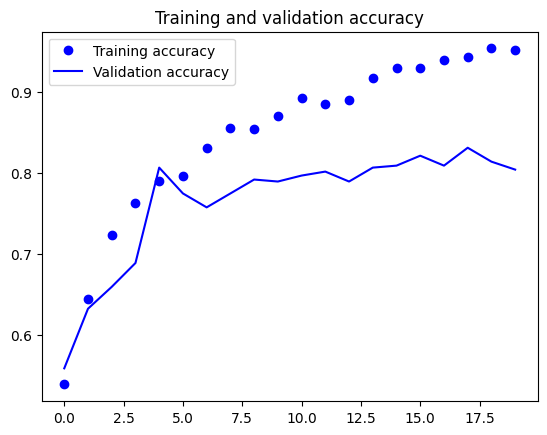

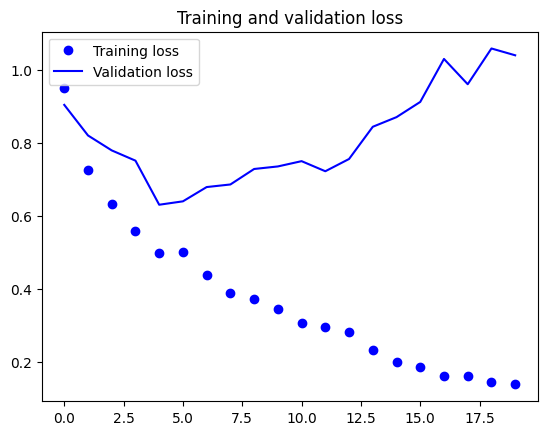

In [51]:
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [52]:
predicted_classes = model.predict(test_X)
# predicted_classes = np.round(predicted_classes).astype(int)

predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
test_Y = np.argmax(np.round(test_Y),axis=1)

predicted_classes[:1]


13/13 [==============================] - 0s 10ms/step


array([2])

In [53]:
predicted_classes.shape, test_Y.shape

((408,), (408,))

Found 328 correct labels


<ipython-input-54-60187154e48e>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


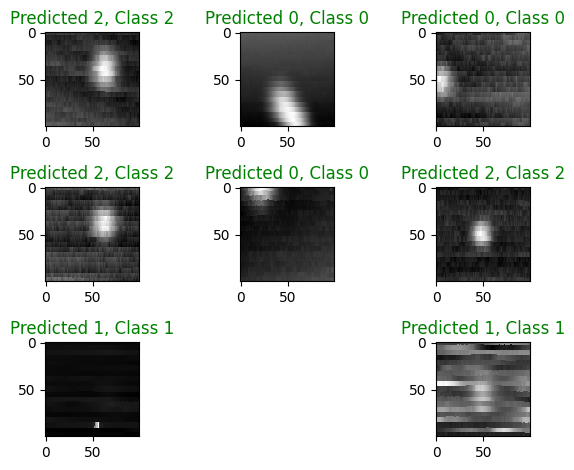

In [54]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found {} correct labels".format(len(correct)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(n,m), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]), color='green')
    plt.tight_layout()


Found 80 incorrect labels


<ipython-input-55-1f82fcc4489f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


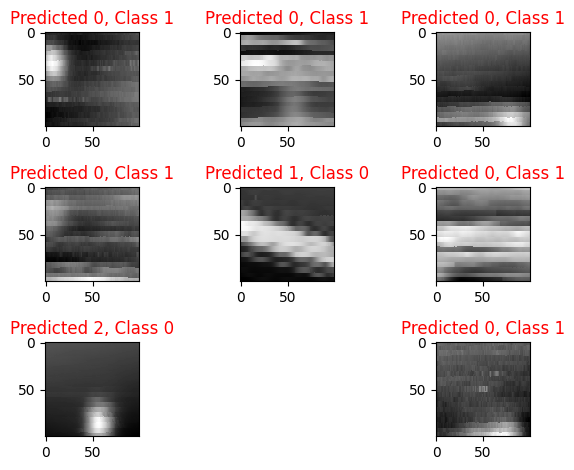

In [55]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found {} incorrect labels".format(len(incorrect)))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(n,m), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]), color='red')
    plt.tight_layout()


In [56]:
from sklearn.metrics import classification_report
# target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(test_Y, predicted_classes, target_names=classes))


              precision    recall  f1-score   support

   BAD_SHAPE       0.71      0.78      0.75       124
    HIGH_RFI       0.82      0.70      0.76       142
        good       0.87      0.93      0.90       142

    accuracy                           0.80       408
   macro avg       0.80      0.80      0.80       408
weighted avg       0.81      0.80      0.80       408



In [57]:
test_Y = [classes[i] for i in test_Y]
predicted_classes = [classes[i] for i in predicted_classes]

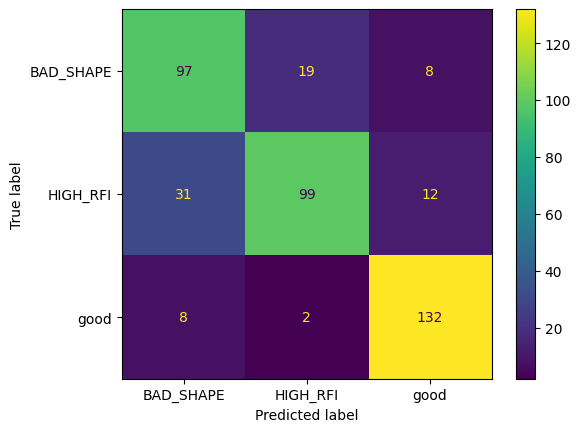

In [58]:
cm = confusion_matrix(test_Y, predicted_classes, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

___
# Save the trained model
___

In [59]:
model.save("/content/drive/MyDrive/data/" + out_mdl_name)
image = rows[0]['image']
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/data/" + out_mdl_name)



In [60]:
"/content/drive/MyDrive/data/" + out_mdl_name

'/content/drive/MyDrive/data/20231017_cnn_model_5Classes.keras'

In [61]:
def predict(image):
    n, m = image.shape
    x = image.reshape(1, n, m, 1)
    x = x.astype(float) / 255.
    pc = reconstructed_model.predict(x, verbose = 0)
    ic = int(np.argmax(np.round(pc),axis=1))

    return classes[ic]

for i in np.random.randint(len(rows), size=10):
    print('{:10.0f} | {} vs. {}'.format(i, predict(rows[i]['image']).rjust(15), rows[i]['tags'].rjust(15)))


       270 |       BAD_SHAPE vs.       BAD_SHAPE
        52 |       BAD_SHAPE vs.       BAD_SHAPE
      1084 |            good vs.       BAD_SHAPE
       778 |        HIGH_RFI vs.        HIGH_RFI
      1379 |       BAD_SHAPE vs.       BAD_SHAPE
       302 |            good vs.            good
       421 |            good vs.            good
       602 |            good vs.            good
       232 |            good vs.            good
      1154 |            good vs.            good
